# Objective

The purpose of this notebook is to familiarize you with the concept of anomaly detection and to walk you through an anomaly detection workflow with an example dataset, from setting up the problem to evaluating the performance of the anomaly detection workflow.

In [118]:
# import standard common libraries

import numpy as np
import matplotlib.pyplot as plt
import torch

# Examining the Data

You have already worked with the CURE-OR dataset in a previous tutorial for object recognition purposes. We are going to use the same dataset in this notebook for the objective of anomaly detection. For this specific notebook, we are going to use the dataset for identifying - for a given class - the training samples for a given background as normal vs from other background conditions as abnormal. In other words, we are going to perform an anomalous background detection. Let us display some data below:

In [119]:
# View the csv file
import pandas as pd
import wget

# # Download the dataset. Keep commented if you already have the data
# urls = ['https://zenodo.org/record/4299330/files/train.zip?download=1',    # data
#         'https://zenodo.org/record/4299330/files/train.csv?download=1'     # data labels
#        ]

# for url in urls:
#     wget.download(url)

df = pd.read_csv('train.csv')
df.head()

,imageID,class,background,perspective,challengeType,challengeLevel
0,0,1,1,1,1,0
1,1,2,1,1,1,0
2,2,3,1,1,1,0
3,3,4,1,1,1,0
4,4,5,1,1,1,0


In [120]:
# Extract photograph IDs from both normal and abnormal conditions for a given class

class_num = 3  # has to be a number between 1 and 10
normal_background = 1  # has to be number from either of 1,2, and 3

train_class_IDs = list(df.loc[(df['class']==class_num) & (df['background']==normal_background)]['imageID'].to_numpy()) # get all the image IDs for that class
train_class_IDs = ['train/'+str(ID).zfill(5)+'.jpg' for ID in train_class_IDs] # convert IDs to string paths

test_class_IDs = list(df.loc[(df['class']==class_num) & (df['background']!=normal_background)]['imageID'].to_numpy()) # get all the image IDs for that class
test_class_IDs = ['train/'+str(ID).zfill(5)+'.jpg' for ID in test_class_IDs] # convert IDs to string paths

In [108]:
# Extract photographs from both challenging and non-challenging conditions

from zipfile import ZipFile

# Extract training images
with ZipFile('train.zip','r') as zipObject:
  for filename in train_class_IDs:
     zipObject.extract(filename, 'in_imgs')

# Extract test images
with ZipFile('train.zip','r') as zipObject:
  for filename in test_class_IDs:
     zipObject.extract(filename, 'out_imgs')        


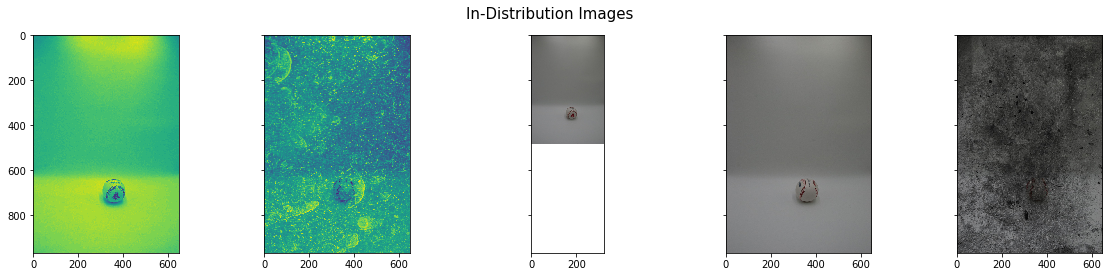

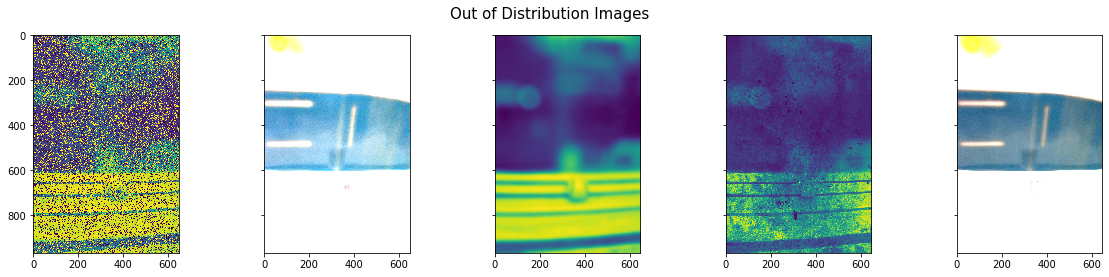

In [121]:
# Display photographs from both train and test sets

import random
from os.path import join
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display 5 random training images
number_imgs = 5
fig, ax = plt.subplots(1,number_imgs, sharey=True, figsize=(20,4))
random.shuffle(train_class_IDs)
filenames = [join('in_imgs',ID) for ID in train_class_IDs][:number_imgs]

for filename,axis in zip(filenames, ax.flatten()):
  img=mpimg.imread(filename)
  axis.imshow(img)

plt.suptitle('In-Distribution Images', fontsize=15)
plt.show()

# Display 5 random test images
number_imgs = 5
fig, ax = plt.subplots(1,number_imgs, sharey=True, figsize=(20,4))
random.shuffle(test_class_IDs)
filenames = [join('out_imgs',ID) for ID in test_class_IDs][:number_imgs]

for filename,axis in zip(filenames, ax.flatten()):
  img=mpimg.imread(filename)
  axis.imshow(img)

plt.suptitle('Out of Distribution Images', fontsize=15)
plt.tight_layout
plt.show()

# Setting up the Model

As you can see above, the training set consists of baseball images only in a white background, whereas the test set contains baseball images from real world backgrounds. In the code cell below, we define the model architecture, which is a convolutional autoencoder with symmetric encoder and decoder structures. 

In [122]:
# set up the convolutional autoencoder model

import torch
import torch.nn as nn

class GradConCAE(nn.Module):
    def __init__(self, in_channel=3):
        super(GradConCAE, self).__init__()

        self.down = nn.Sequential(
            nn.Conv2d(in_channel, 32, 4, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, 4, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 4, stride=2, padding=2),
            nn.ReLU()
        )

        self.up = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=2),  # output 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # output 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 4, stride=2, padding=1),  # output 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channel, 4, stride=2, padding=1),  # output 28x28
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        z = self.down(x)
        return self.up(z)


# Define Dataset class

In the code cell below, we define the dataset class 

In [123]:
import os

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class anomaly_dataset_loader(Dataset):
    """Class definition for dataset loader"""
    
    def __init__(self, path_list):
        """Function takes in list of paths for images  to be loaded"""
        self.paths = path_list
        self.transform = transforms.Compose([transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                   std=[0.229, 0.224, 0.225]),
                                              ])
        
        
    def __getitem__(self, index):
        """Access image at position specified by index"""
        im_path = self.paths[index]  # access image path
        str_list = im_path.split('_')  # split path at the position speicifed by underscore
        label = 1 if str_list[0]=='in' else 0  # sample is normal if it comes from the training directory, assigned a label of 1, else 0 (denoting anomalous)
        
        im = Image.open(im_path).convert('RGB')
        im = self.transform(im)  # load image and preprocess
        im = im.to('cuda')
        
        return im, label 
     
    def __len__(self):
        return len(self.paths)
    
    

# Defining the Dataloaders

Having written the dataset class, we now set up dataloaders for both training and test data. Note that the way we are setting up this anomaly detection workflow is to train the convolutional autoencoder purely on in-distribution (normal) data as specified by the class and its background above. These training samples would form part of our training data. On the other hand, out-of-distribution (anomalous) data samples are images from other backgrounds (or even classes). The test dataset would form a mix of in- and out- of distribution training samples. For our purposes, we will assume a 50/50 ratio for in- and out-of-distribution samples.



In [124]:
from torch.utils.data import DataLoader

train_size = 100  # number of training samples in training set
test_size = 100 # number of test samples
in_out_ratio = 0.5 # ration of normal and abnormal samples in test
in_samples_test_set = int(in_out_ratio*test_size)
out_samples_test_set = test_size - in_samples_test_set

# Extract training filenames
random.shuffle(train_class_IDs)
train_file_paths = [join('in_imgs',ID) for ID in train_class_IDs][:train_size]

# Extract test filenames
random.shuffle(test_class_IDs)
test_file_paths = [join('out_imgs',ID) for ID in test_class_IDs][:out_samples_test_set] + [join('in_imgs',ID) for ID in train_class_IDs][-in_samples_test_set:]

# set up training and test loaders 
train_loader = DataLoader(anomaly_dataset_loader(train_file_paths), batch_size=1)
test_loader = DataLoader(anomaly_dataset_loader(test_file_paths), batch_size=1)

# Setting up the Training Loop

Having set up the data for training, we now commence the training loop. We use Adam optimizer with learning rate of 0.001 and Mean Squared Error as the loss to measure reconstruction performance.

In [125]:
num_epochs = 20  # num of epochs for training 

model = GradConCAE().cuda()  # defines model
loss_func = torch.nn.MSELoss()  # MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # adam optimizer

model.train()
for epoch in range(num_epochs):
    for batch_idx, (img, in_out_label) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_img = model(img)
        loss = loss_func(img, recon_img)
        loss.backward()
        optimizer.step()
        
#         if batch_idx%10==0:
#             print("Epoch: {} | Loss: {}".format(epoch, loss.item()))
                   
    print("Epoch: {} | Loss: {}".format(epoch, loss.item()))
                   

Epoch: 0 | Loss: 0.13990437984466553
Epoch: 1 | Loss: 0.08756551146507263
Epoch: 2 | Loss: 0.08232880383729935
Epoch: 3 | Loss: 0.0917365700006485
Epoch: 4 | Loss: 0.05148863419890404
Epoch: 5 | Loss: 0.04814350605010986
Epoch: 6 | Loss: 0.038726575672626495
Epoch: 7 | Loss: 0.03725295886397362
Epoch: 8 | Loss: 0.03754623979330063
Epoch: 9 | Loss: 0.03713098540902138
Epoch: 10 | Loss: 0.037074003368616104
Epoch: 11 | Loss: 0.0379246361553669
Epoch: 12 | Loss: 0.03450563922524452
Epoch: 13 | Loss: 0.03343762457370758
Epoch: 14 | Loss: 0.03366694226861
Epoch: 15 | Loss: 0.03309786692261696
Epoch: 16 | Loss: 0.03197210282087326
Epoch: 17 | Loss: 0.03304322063922882
Epoch: 18 | Loss: 0.03170853853225708
Epoch: 19 | Loss: 0.032958127558231354


# Perform Inference

Having trained the network, we will now perform inference on the test set to see if each image there is an in (label 1) or or out-of-distribution sample (label 0). 

In [126]:
y_true = np.zeros(test_size)  # set up an array to store true positive labels
scores = np.zeros(y_true.shape)  # array to store confidence scores for predicting positive class.

model.eval()  # set model to evaluate mode 
for i, (img, in_out_label) in enumerate(test_loader):
    img_recon = model(img)
    loss = loss_func(img, recon_img)
    
    y_true[i] = in_out_label
    scores[i] = -loss.detach().cpu().numpy()
    

# Plotting ROC

Having obtained unnormalized confidence scores on test set, we now plot the ROC curve.

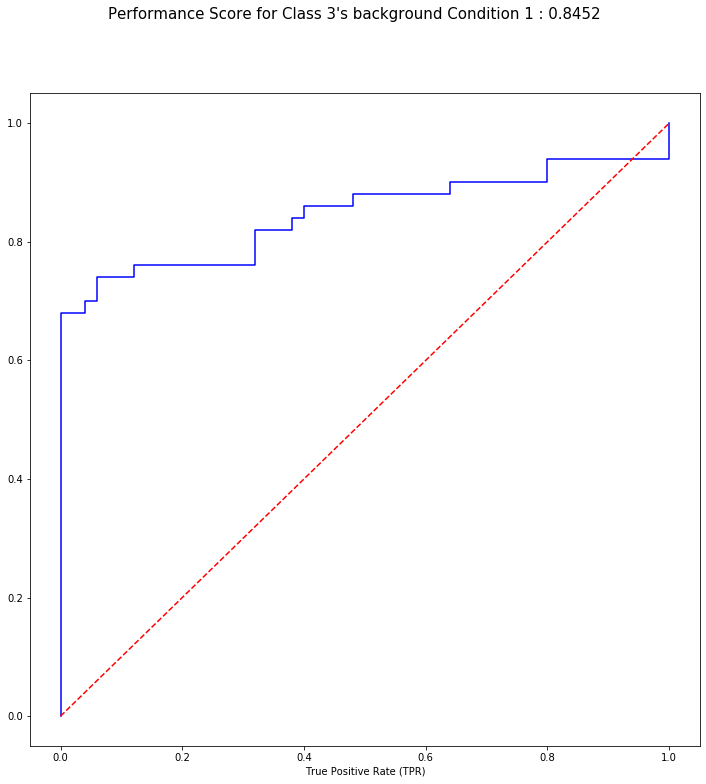

In [127]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_true, scores, pos_label=1) # obtain true and false positive rates
auroc = roc_auc_score(y_true, scores) # obtain auroc

# plot ROC
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(fpr, tpr, 'b-', label='ROC Curve')
ax.plot([0,1],[0,1],'r--')
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
plt.suptitle("Performance Score for Class {}'s background Condition {} : {:0.4f}".format(class_num, normal_background, auroc), fontsize=15)
plt.show()             


# Food for Thought

As you can see, this is a pretty good anomaly detector, and was able to classify the normal from abnormal samples pretty well. Try out different combinations of class and background. See if the anomaly detector is able to perform as well for all classes.
